# Implementación de SGD para la función XOR

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Función sigmoidea

In [122]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

## Función de pérdida

In [123]:
def loss(y, y_pred):
  diff = y - y_pred
  return np.mean(diff**2)

## Función de predicción

In [124]:
def predict(x, w):
  
  # Reordeno vector de parametros como matriz de 3x3, donde cada columna contiene los parámetro de cada neurona
  W = np.reshape(w, (3, 3)).T

  # Calculo z para las neuronas de la capa 1
  z_L1 = x @ W[:, :-1]
  # Calculo la salida para las neuronas de la capa 1 (incluyendo termino independiente)
  a_L1 = np.append(sigmoid(z_L1), np.array([1]))

  # Calculo salida de la neurona de la capa 2
  z_L2 = np.dot(a_L1, W[:, -1]) #Prediccion para la i-esima fila del dataset

  return [z_L2, a_L1, z_L1, W]

In [125]:
y_true=.23434445
x=np.array([2, 5, 1])
w=np.random.rand(9)
fwd = predict(x,w)
print(fwd)

[1.2527102709933111, array([0.96071582, 0.98984764, 1.        ]), array([3.1968568 , 4.57984483]), array([[0.51716863, 0.06870169, 0.54497975],
       [0.39971932, 0.83502598, 0.5786994 ],
       [0.16392292, 0.26731157, 0.15631537]])]


## Función para calcular el gradiente de la función de perdida respecto a los parámetros del modelo

In [126]:
def gradient(x, err, pred_vars):
  # Derivada de loss respecto a la y_pred
  dL_dypred = -2*err
  z_L2, a_L1, z_L1, W = pred_vars[0], pred_vars[1], pred_vars[2], pred_vars[3]
  
  # Derivada respecto a los parámetros de la capa L2
  dL_w2b2 = dL_dypred*a_L1

  # Derivada respecto a los parámetros de la capa L1
  dypred_da1 = W[0:2, -1]
  da1_dz1 = sigmoid(z_L1)*(1-sigmoid(z_L1))
  dypred_dz1 = dypred_da1*da1_dz1
  dL_w1b1 = dL_dypred*np.tensordot(x, dypred_dz1, axes=0)

  # Gradiente
  gradJ = np.reshape(dL_w1b1.T, (6,)) #Primero debo trasponer para que la salida sea el apilamiento de las columnas de la matriz
  gradJ = np.append(gradJ, dL_w2b2)
  
  return gradJ

In [127]:
grad1 = gradient(x,y_true-fwd[0],fwd)
print(grad1)

[0.08378317 0.20945793 0.04189159 0.0236893  0.05922325 0.01184465
 1.95672031 2.01605401 2.03673164]


## Derivada numerica

In [128]:
def NumDiff(y, y_pred0, x, w0):
  nw = len(w0)
  dw = 1e-6
  f0 = loss(y, y_pred0)
  grad = []
  for i in range(nw):
    w = np.copy(w0)
    w[i] = w[i] + dw
    pred = predict(x, w)
    y_pred = pred[0]
    f = loss(y, y_pred)
    df_dw = (f-f0)/dw
    grad.append(df_dw)

  return np.asarray(grad)


In [129]:
grad2 = NumDiff(y_true, fwd[0], x, w)
print(grad2)

[0.08378309 0.20945745 0.04189157 0.02368927 0.0592231  0.01184464
 1.95672124 2.01605499 2.03673264]


## Comprobación entre derivada numérica y derivada calculada por diferenciacion automática

In [130]:
grad1/grad2

array([1.0000009 , 1.00000225, 1.00000046, 1.000001  , 1.00000244,
       1.00000049, 0.99999953, 0.99999951, 0.99999951])

## Algortimo SGD

In [131]:
def sgd(X, y, w, lr, epochs):
  N, d = X.shape
  MSE = []
  for i in range(epochs):
    for j in range(N):
      # Selecciono fila j del dataset
      x_j = X[j,:]
      # Selecciono componente j de la variable target
      y_j = y[j]
      # Paso forward utilizando la fila j
      pred_vars = predict(x_j, w)
      y_pred_j = pred_vars[0]
      # Calculo del residuo
      err_j = y_j - y_pred_j
      # Paso backpropagation
      gradJ = gradient(x_j, err_j, pred_vars)
      # Derivada numérica
      gradJ2 = NumDiff(y_j, y_pred_j, x_j, w) 
      # Comparacion backprop y derivada numerica
      #print("Derivada computada por backpropagation:", gradJ)
      #print("Derivada computada por diferencias finitas:", gradJ2)
      #print("Relación entre las derivadas:", gradJ/gradJ2)
      # Actualizacion de pesos
      w = w - lr*gradJ
    
    y_pred = np.empty((N,))
    for j in range(N):
      pred_vars = predict(X[j,:], w)
      y_pred[j] = pred_vars[0]
    
    mse = loss(y, y_pred)
    MSE.append(mse)
    print("Epoch:", i, "MSE:", mse)

  return w, MSE

## Main - Minimización utilizando SGD en el problema de ajuste a la función XOR

In [132]:
# Dataset
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

N, d = X.shape

# Agrego columna de unos
X = np.append(X, np.ones((N,1)), axis=1)

# Variable target
y = np.array([0, 1, 1, 0])

# Arquitectura de la ANN
n_layers = 2
neuronas_L1 = 2
neuronas_L2 = 1

# Hiperparámetros del modelo
learningRates = np.linspace(0.1, 1, 10) # Learning rates
epochs = 200 # N° de iteraciones máximas de SGD

# Inicializacion random de los parámetros del modelo
n_param = 9
w0 = np.random.uniform(low=0.0, high=1.0, size=n_param) #np.random.uniform(low=0.0, high=1.0, size=n_param) #np.random.rand(n_param)

# Llamada al algoritmo de Stochastic Gradient Descent para cada uno de los learning rate considerados
MSE = []
W = []
for lr in learningRates:
    w_i, MSE_i = sgd(X, y, w0, lr, epochs)
    W.append(w_i)
    MSE.append(MSE_i)


Epoch: 0 MSE: 0.2484211968670299
Epoch: 1 MSE: 0.2588198255684421
Epoch: 2 MSE: 0.2617199824690051
Epoch: 3 MSE: 0.26196721103362663
Epoch: 4 MSE: 0.2619113426410273
Epoch: 5 MSE: 0.26182291033199145
Epoch: 6 MSE: 0.2617309801533108
Epoch: 7 MSE: 0.2616386503278945
Epoch: 8 MSE: 0.2615462407574354
Epoch: 9 MSE: 0.2614537741435039
Epoch: 10 MSE: 0.2613612420758341
Epoch: 11 MSE: 0.2612686336584457
Epoch: 12 MSE: 0.2611759385963906
Epoch: 13 MSE: 0.26108314752703105
Epoch: 14 MSE: 0.2609902520536277
Epoch: 15 MSE: 0.2608972447472204
Epoch: 16 MSE: 0.2608041191456352
Epoch: 17 MSE: 0.26071086975269453
Epoch: 18 MSE: 0.2606174920379058
Epoch: 19 MSE: 0.2605239824365957
Epoch: 20 MSE: 0.2604303383504215
Epoch: 21 MSE: 0.2603365581481899
Epoch: 22 MSE: 0.26024264116690976
Epoch: 23 MSE: 0.2601485877130081
Epoch: 24 MSE: 0.26005439906363387
Epoch: 25 MSE: 0.2599600774679789
Epoch: 26 MSE: 0.25986562614853903
Epoch: 27 MSE: 0.2597710493022441
Epoch: 28 MSE: 0.2596763521013784
Epoch: 29 MSE: 0.

Text(0, 0.5, 'MSE')

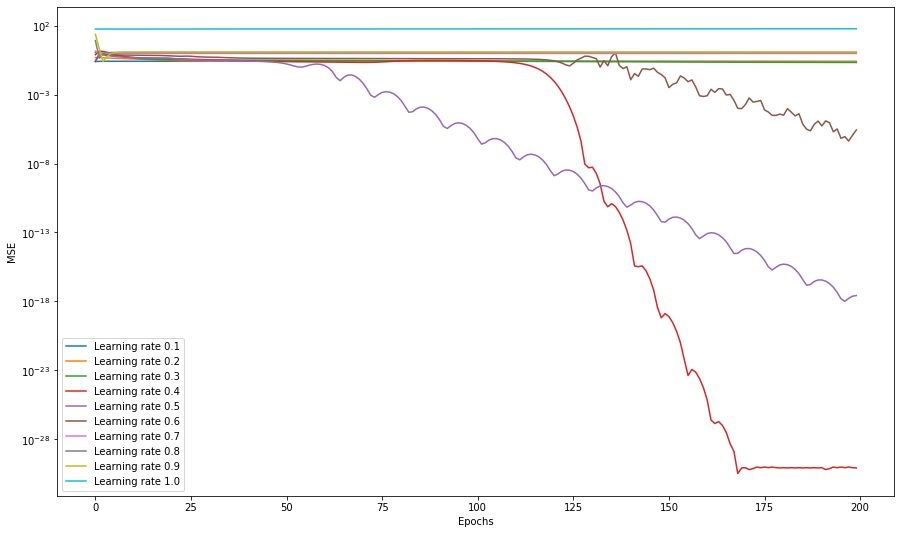

In [133]:
# Grafica
colores = list(mcolors.TABLEAU_COLORS.keys())
fig, axs = plt.subplots(1, sharey=True, figsize=(15, 9))
for i, lr in enumerate(learningRates):
    axs.semilogy(np.arange(epochs), MSE[i], linewidth=1.5, color=colores[i], label='Learning rate '+str(round(lr,2)))
    axs.legend()

axs.axes.set_xlabel('Epochs')
axs.axes.set_ylabel('MSE')

In [134]:
# Comparacion parametros originales vs parametros ajustados
idx = np.where(learningRates==0.4) # Del grafico anterior, lr=0.4 fue el que permitio reducir la funcion de pérdida en mayor medida
w = W[idx[0][0]]
print("Parámetros originales:", w0)
print("Parámetros aprendidos:", w)

# Prediccion
y_pred = []
for i in range(N):
  pred_i = predict(X[i, :], w)
  y_pred_i = pred_i[0]
  y_pred.append(y_pred_i)

print("Salida real:", y.flatten())
print("Predicción:", y_pred)

Parámetros originales: [0.45908858 0.72433083 0.69169953 0.77982005 0.67547505 0.40036581
 0.74462291 0.48113549 0.82757268]
Parámetros aprendidos: [-4.56898535  4.58562133 -3.73175379 -2.32276325  2.32456765 -0.1717525
  3.30376407 -2.82591252  1.21463735]
Salida real: [0 1 1 0]
Predicción: [1.1102230246251565e-15, 1.0000000000000002, 1.0000000000000009, 1.1102230246251565e-15]


## Conclusión
La red neuronal fue capaz de predecir con exactitud la salida de la función XOR haciendo uso de un learning rate correcto.